### Projeto Final 
**Grupo:**
- Adriano Felipe Cabral Filho (afcf)
- Felipe Rodrigues de Souza (frs3)
- Lucas Vinícius José da Silva (lvjs)
- Pedro José Carneiro de Souza (pjcs) 
- Vitor Sousa Silva (vss2)


In [1]:
import time
import optuna
import numpy as np
import pandas as pd
from numpy import std
from numpy import mean
import scikitplot as skplt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from random import randint
from tensorflow import keras 

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score, plot_confusion_matrix

ds = pd.read_csv('TRNcod.xls', delimiter = "\t")

# Shuffle no dataset
ds = ds.sample(frac=1).reset_index(drop=True)

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
        plt.suptitle('Acurácia: {:3.3f}\nRecall: {:3.3f}\nPrecision: {:3.3f}\nF1: {:3.3f}\nAUROC: {:3.3f}\nAURP: {:3.3f}'.format(accuracy, recall, precision, f1, auroc, aupr), x=0.25, y=0.8)
    return performance_metrics

def compute_performance_metrics_sem_plot(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        # skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        # plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def compute_performance_metrics_sem_plot2(y, y_pred_class, y_pred_scores, rede_trial):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        # plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
        plt.title(label=rede_trial, y=0.9)
        plt.suptitle('Acurácia: {:3.3f}\nRecall: {:3.3f}\nPrecision: {:3.3f}\nF1: {:3.3f}\nAUROC: {:3.3f}\nAURP: {:3.3f}'.format(accuracy, recall, precision, f1, auroc, aupr), x=0.25, y=0.8)
        plt.savefig(rede_trial, dpi=100)
        plt.close()
    return performance_metrics

In [ ]:
# print([d for d in ds.columns])

#### Tratamento do Dataset

In [2]:
# inadimplentes = pd.DataFrame(list(filter(lambda x: x == 1, ds['IND_BOM_1_2'])))

# Selecionando quem é inadimplente
inadimplentes = ds[ds['IND_BOM_1_2'] == 1]

# Selecionando quem é adimplente
adimplente = ds[ds['IND_BOM_1_2'] == 0]

global treino_ina
global teste_ina
global valid_ina
global treino_adi
global teste_adi
global valid_adi


# Dividindo datasets
treino_ina = inadimplentes[:int(len(inadimplentes)/2)]
teste_ina  = inadimplentes[int(len(inadimplentes)/2):int((len(inadimplentes)*3)/4)]
valid_ina  = inadimplentes[int((len(inadimplentes)*3)/4):]

treino_adi = adimplente[:int(len(adimplente)/2)]
teste_adi  = adimplente[int(len(adimplente)/2):int((len(adimplente)*3)/4)]
valid_adi  = adimplente[int((len(adimplente)*3)/4):]

# Equalizando tamanho de datasets treino e validação dos inadimplentes ao de adimplentes
treino_ina = treino_ina.loc[treino_ina.index.repeat(2)].drop('INDEX', axis=1)
treino_ina["COPIA"] = treino_ina.duplicated()
treino_ina.sort_values(by="COPIA", inplace=True, ignore_index=True)
treino_ina = treino_ina.iloc[ : ( len(treino_adi) - len(treino_ina) ), :  ]
treino_ina.drop(columns=["COPIA"], axis=1, inplace=True)

treino_adi.drop(columns=['INDEX'], axis=1, inplace=True)

valid_ina  = valid_ina.loc[valid_ina.index.repeat(2)].drop('INDEX', axis=1)
valid_ina["COPIA"] = valid_ina.duplicated()
valid_ina.sort_values(by="COPIA", inplace=True, ignore_index=True)
valid_ina = valid_ina.iloc[ : ( len(valid_adi) - len(valid_ina) ), :  ]
valid_ina.drop(columns=["COPIA"], axis=1, inplace=True)
# Fim da equalização

print('Tamanhos de inadimplentes: \nTreino: {}\nTeste: {}\nValidação: {}\n'.format(len(treino_ina.values), len(teste_ina.values), len(valid_ina.values)))
print('Tamanhos de adimplentes: \nTreino: {}\nTeste: {}\nValidação: {}\n'.format(len(treino_adi.values), len(teste_adi.values), len(valid_adi.values)))
print('Colunas: {}'.format(len([d for d in ds.columns])))
ds.drop(labels="INDEX", axis=1, inplace=True)

Tamanhos de inadimplentes: 
Treino: 127549
Teste: 33524
Validação: 63775

Tamanhos de adimplentes: 
Treino: 127549
Teste: 63774
Validação: 63775

Colunas: 246


In [3]:
# https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
# https://psicometriaonline.com.br/como-testar-a-normalidade-da-amostra-com-kolgomorov-smirnov-e-shapiro-wilk/

# # Create correlation matrix
# corr_matrix = ds.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find features with correlation greater than 0.89
# to_drop = [column for column in upper.columns if any(upper[column] > 0.89)]

# # Drop features 
# # ds.drop(to_drop, axis=1, inplace=True)
# ds.columns


# Colunas mais correlacionadas
# l = []
# for c in ds.columns[:-1]:
#     l.append({c: ds[c].corr(ds['IND_BOM_1_1'])})
#     # if (ds[c].corr(ds['IND_BOM_1_1']) > 0.0):
#         # print( c, ds[c].corr(ds['IND_BOM_1_1']) )
# l.sort(key=lambda x: list(x.values())[0])
# print(l)

## MLP

[I 2021-12-12 20:40:00,301] A new study created in memory with name: no-name-5eef8c69-9c6f-47d8-a5c4-ecc8d67965ca
[I 2021-12-12 20:40:18,250] Trial 0 finished with value: 0.6264288514308114 and parameters: {'layers': 1, 'solver': 'adam', 'neurons': 18, 'activation': 'logistic', 'learning rate': 'constant', 'initial learning rate': 0.09109204532809982}. Best is trial 0 with value: 0.6264288514308114.
[I 2021-12-12 20:40:40,852] Trial 1 finished with value: 0.6360721285770287 and parameters: {'layers': 2, 'solver': 'adam', 'neurons': 15, 'activation': 'logistic', 'learning rate': 'constant', 'initial learning rate': 0.02671932906926546}. Best is trial 1 with value: 0.6360721285770287.
[I 2021-12-12 20:41:46,359] Trial 2 finished with value: 0.6304978439827519 and parameters: {'layers': 2, 'solver': 'lbfgs', 'neurons': 12, 'activation': 'identity', 'learning rate': 'adaptive', 'initial learning rate': 0.03621666853560101}. Best is trial 1 with value: 0.6360721285770287.
[I 2021-12-12 20:4

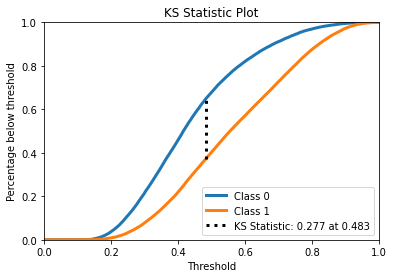

<Figure size 432x288 with 0 Axes>

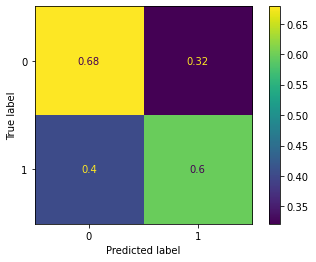

In [3]:
df_treino = treino_ina.drop(axis=1, labels=['IND_BOM_1_1', 'IND_BOM_1_2']).append(treino_adi.drop(axis=1, labels=['IND_BOM_1_1', 'IND_BOM_1_2']))
df_teste = teste_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(teste_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_teste.drop(columns=['INDEX'], axis=1, inplace=True)
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)

best_mlp = []

def mlp(trial):
    layers              = trial.suggest_int('layers', 1, 2)
    solver              = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    neurons             = trial.suggest_int('neurons', 2, 32)
    activation          = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    learning_rate       = trial.suggest_categorical('learning rate', ['constant', 'adaptive'])
    learning_rate_init  = trial.suggest_float('initial learning rate', 0.001, 0.1)
    mlp = MLPClassifier(random_state=1, 
                    max_iter=10000,
                    solver=solver,
                    activation=activation,
                    learning_rate=learning_rate,
                    hidden_layer_sizes=(neurons,) if layers==1 else (neurons, neurons),
                    learning_rate_init=learning_rate_init, 
                    early_stopping=True).fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))

    best_mlp.append(mlp)

    mlp_pred_class = mlp.predict(df_validacao)
    mlp_pred_scores = mlp.predict_proba(df_validacao)

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics_sem_plot2([0]*len(valid_ina)+[1]*len(valid_adi), mlp_pred_class, mlp_pred_scores, "MLP/MLP Trial {}".format(trial.number))

    return accuracy

study_0 = optuna.create_study(direction="maximize")
study_0.optimize(mlp, n_trials=64)

compute_performance_metrics([0]*len(teste_ina)+[1]*len(teste_adi), best_mlp[study_0.best_trial.number].predict(df_teste), best_mlp[study_0.best_trial.number].predict_proba(df_teste))
plot_confusion_matrix(best_mlp[study_0.best_trial.number], df_teste, [0]*len(teste_ina)+[1]*len(teste_adi), normalize='true')

#### Plot da matriz de confusão do melhor classificador dentre os testados acima

### Resultados do MLP

In [4]:
optuna.visualization.plot_optimization_history(study_0)

In [5]:
optuna.visualization.plot_slice(study_0)

In [6]:
optuna.visualization.plot_param_importances(study_0)

#### Comentários acerca dos resultados do MLP

## Random Forest

In [ ]:
# Cuidado: usar esses parâmetros muito elevados, ou o default (100 estimadores e profundidade ilimitada) vai travar seu computador

# Parâmetros default:
# n_estimators=100, *,
# criterion="gini",
# max_depth=None,
# min_samples_split=2,
# min_samples_leaf=1,
# min_weight_fraction_leaf=0.,
# max_features="auto",
# max_leaf_nodes=None,
# min_impurity_decrease=0.,
# min_impurity_split=None,
# bootstrap=True,
# oob_score=False,
# n_jobs=None,
# random_state=None,
# verbose=0,
# warm_start=False,
# class_weight=None,
# ccp_alpha=0.0,
# max_samples=None

#### Teste de Kolmogorov-Smirnov (KS) e matriz de confusão da Random Forest
Acima, podemos ver os resultados de ambos. O teste de Kolmogorov-Smirnov assemelha-se bastante a uma distribuição normal. A matriz foi bem sucedida para identificar resultados falsos,  para casos verdadeiro seu resultado foi pouco acima de 50%.

In [3]:
ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)

best_rf = []

def rf(trial):
    max_depth           = trial.suggest_int("max_depth", 16, 64)
    criterion           = trial.suggest_categorical("criterion", ["gini", "entropy"])
    n_estimators        = trial.suggest_int("n_estimators", 8, 32)
    min_samples_leaf    = trial.suggest_int("min_samples_leaf", 2, 8)
    min_samples_split   = trial.suggest_int("min_samples_split", 2, 8)
    random_forest = RandomForestClassifier(n_estimators=n_estimators, 
                                        max_depth=max_depth, 
                                        criterion=criterion, 
                                        bootstrap=True, 
                                        min_samples_leaf=min_samples_leaf, 
                                        min_samples_split=min_samples_split).fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))

    # Código opcional para logar e cronometrar tempo
    # print('Random Forest com {} estimadores e profundidade máxima {}, critério {}, min amostras de folhas {} e min divisão de amostras {}\n'.format(
    #     n_estimators, max_depth, criterion, min_samples_leaf, min_samples_split
    # ))
    # start = time.time()
    # n_scores = cross_val_score(random_forest, ds_dropado, ds['IND_BOM_1_2'], scoring='accuracy', n_jobs=1, error_score='raise')
    # print('Acurácia e desvio padrão: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    # print("Tempo: ", format(time.time() - start, '.3f'), 's\n', sep='')

    best_rf.append(random_forest)

    rf_pred_class  = random_forest.predict(df_validacao)
    rf_pred_scores = random_forest.predict_proba(df_validacao)

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics_sem_plot2([0]*len(valid_ina)+[1]*len(valid_adi), rf_pred_class, rf_pred_scores, "RF/RF Trial {}".format(trial.number))
    
    return accuracy

study_1 = optuna.create_study(direction="maximize")
study_1.optimize(rf, n_trials=64)


[I 2021-12-13 09:53:46,701] A new study created in memory with name: no-name-645ee9d7-04f2-49f6-b887-c3745391ff0c
[I 2021-12-13 09:54:27,698] Trial 0 finished with value: 0.6122540180321443 and parameters: {'max_depth': 62, 'criterion': 'gini', 'n_estimators': 20, 'min_samples_leaf': 4, 'min_samples_split': 8}. Best is trial 0 with value: 0.6122540180321443.
[I 2021-12-13 09:54:47,460] Trial 1 finished with value: 0.6049392395139161 and parameters: {'max_depth': 37, 'criterion': 'gini', 'n_estimators': 10, 'min_samples_leaf': 5, 'min_samples_split': 6}. Best is trial 0 with value: 0.6122540180321443.
[I 2021-12-13 09:55:08,387] Trial 2 finished with value: 0.5943237945903567 and parameters: {'max_depth': 55, 'criterion': 'entropy', 'n_estimators': 9, 'min_samples_leaf': 3, 'min_samples_split': 2}. Best is trial 0 with value: 0.6122540180321443.
[I 2021-12-13 09:55:55,276] Trial 3 finished with value: 0.6175460603684829 and parameters: {'max_depth': 57, 'criterion': 'gini', 'n_estimator

NameError: name 'df_teste' is not defined

#### Plot da matriz de confusão do melhor classificador dentre os testados acima

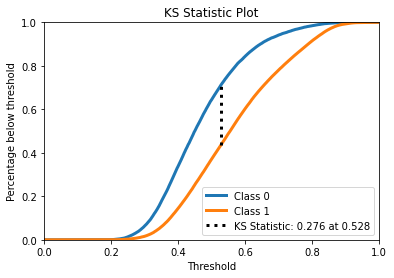

<Figure size 432x288 with 0 Axes>

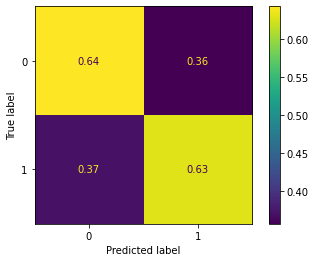

In [4]:
df_teste = teste_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(teste_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_teste.drop(columns=['INDEX'], axis=1, inplace=True)
compute_performance_metrics([0]*len(teste_ina)+[1]*len(teste_adi), best_rf[study_1.best_trial.number].predict(df_teste), best_rf[study_1.best_trial.number].predict_proba(df_teste))
plot_confusion_matrix(best_rf[study_1.best_trial.number], df_teste, [0]*len(teste_ina)+[1]*len(teste_adi), normalize='true')

### Resultados da Random Forest

In [5]:
optuna.visualization.plot_optimization_history(study_1)

In [6]:
optuna.visualization.plot_slice(study_1)

In [7]:
optuna.visualization.plot_param_importances(study_1)

#### Comentários acerca dos resultados da Random Forest

A profundidade máxima é, sem dúvidas, o maior diferencial entre todos os hiperparâmetros, e menores profundidades são melhores; é possível perceber através do gráfico que quanto maior a profundidade melhor vai ser o desempenho, até atingir-se um limite. A quantidade de estimadores tem um impacto bastante menor, no gráfico, é possível ver que, excluindo-se os outliers, o número de estimadores realmente não interfere bastante no resultado final. A quantidade mínima de samples nas folhas tem impacto ainda menor, pode-se dizer que é inútil alterar este parâmetro.


### Teste com profundidade menor

In [8]:
def rf(trial):
    max_depth           = trial.suggest_int("max_depth", 2, 16)
    criterion           = trial.suggest_categorical("criterion", ["gini", "entropy"])
    n_estimators        = trial.suggest_int("n_estimators", 8, 32)
    min_samples_leaf    = trial.suggest_int("min_samples_leaf", 2, 8)
    min_samples_split   = trial.suggest_int("min_samples_split", 2, 8)
    random_forest = RandomForestClassifier(n_estimators=n_estimators, 
                                        max_depth=max_depth, 
                                        criterion=criterion, 
                                        bootstrap=True, 
                                        min_samples_leaf=min_samples_leaf, 
                                        min_samples_split=min_samples_split).fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))

    rf_pred_class  = random_forest.predict(df_validacao)
    rf_pred_scores = random_forest.predict_proba(df_validacao)

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics_sem_plot([0]*len(valid_ina)+[1]*len(valid_adi), rf_pred_class, rf_pred_scores)
    
    return accuracy

study_1 = optuna.create_study(direction="maximize")
study_1.optimize(rf, n_trials=64)


[I 2021-12-13 10:51:57,381] A new study created in memory with name: no-name-f01eceaf-879c-435b-b6ec-274904bcbc97
[I 2021-12-13 10:52:39,920] Trial 0 finished with value: 0.6385966287730301 and parameters: {'max_depth': 14, 'criterion': 'entropy', 'n_estimators': 26, 'min_samples_leaf': 7, 'min_samples_split': 3}. Best is trial 0 with value: 0.6385966287730301.
[I 2021-12-13 10:52:55,472] Trial 1 finished with value: 0.624076832614661 and parameters: {'max_depth': 6, 'criterion': 'entropy', 'n_estimators': 20, 'min_samples_leaf': 8, 'min_samples_split': 6}. Best is trial 0 with value: 0.6385966287730301.
[I 2021-12-13 10:53:07,963] Trial 2 finished with value: 0.626765974127793 and parameters: {'max_depth': 7, 'criterion': 'entropy', 'n_estimators': 14, 'min_samples_leaf': 4, 'min_samples_split': 7}. Best is trial 0 with value: 0.6385966287730301.
[I 2021-12-13 10:53:30,821] Trial 3 finished with value: 0.6291807134457076 and parameters: {'max_depth': 7, 'criterion': 'entropy', 'n_esti

In [9]:
optuna.visualization.plot_optimization_history(study_1)

In [10]:
optuna.visualization.plot_slice(study_1)

In [11]:
optuna.visualization.plot_param_importances(study_1)

#### Comentários acerca dos resultados da segunda execução

Os resultados foram melhores, é possível perceber uma tendência de crescimento em torno do 16, entretanto, a melhora foi de menos de 1% (a melhora foi de 0.04%). Tendo em vista que esta execução foi mais rápida (11 minutos a menos) que a primeira (que demorou um total de 50 minutos), então, o teste foi válido.

## Gradient Boosting

In [ ]:
# Parâmetros default:
# *,loss='deviance', 
# learning_rate=0.1, 
# n_estimators=100,
# subsample=1.0, 
# criterion='friedman_mse', 
# min_samples_split=2,
# min_samples_leaf=1, 
# min_weight_fraction_leaf=0.,
# max_depth=3, 
# min_impurity_decrease=0.,
# min_impurity_split=None, 
# random_state=None, 
# max_features=None, verbose=0,
# max_leaf_nodes=None, 
# warm_start=False,
# validation_fraction=0.1, 
# n_iter_no_change=None, 
# tol=1e-4,
# ccp_alpha=0.0

#### Teste de Kolmogorov-Smirnov (KS) e matriz de confusão da Gradient Boosting
Acima, podemos ver os resultados de ambos. O teste de Kolmogorov-Smirnov assemelha-se, assim como a Random Forest, bastante a uma distribuição normal. Mais uma vez (semelhante a Random Forest), a matriz foi bem sucedida para identificar resultados falsos, para casos verdadeiro seu resultado foi pouco acima de 50%. Podemos afirmar que para apenas um teste, o Gradient Boosting se saiu melhor.

In [ ]:
ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)
df_teste = teste_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(teste_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_teste.drop(columns=['INDEX'], axis=1, inplace=True)

best_gb = []

def gb(trial):
    loss                = trial.suggest_categorical("loss", ["deviance", "exponential"])
    max_depth           = trial.suggest_int("max_depth", 16, 64)
    subsample           = trial.suggest_float("subsample", 0.01, 0.7)
    n_estimators        = trial.suggest_int("n_estimators", 8, 32)
    learning_rate       = trial.suggest_float("learning_rate", 0.01, 0.7)
    min_samples_leaf    = trial.suggest_int("min_samples_leaf", 2, 8)
    
    # Código opcional para logar execuções
    # print('Gradient Boosting com {} estimadores e profundidade máxima {}, critério {}, min amostras de folhas {}, subsample de {} e taxa de aprendizagem {}\n'.format(
    #     n_estimators, max_depth, loss, min_samples_leaf, subsample, learning_rate
    # ))


    gradient_boost = GradientBoostingClassifier(n_estimators = n_estimators, 
                                            max_depth = max_depth, 
                                            min_samples_leaf = min_samples_leaf, 
                                            learning_rate = learning_rate, 
                                            loss = loss, 
                                            subsample = subsample).fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))
    best_gb.append(gradient_boost)
    
    gb_pred_class = gradient_boost.predict(df_validacao)
    gb_pred_scores = gradient_boost.predict_proba(df_validacao)
    
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics_sem_plot2([0]*len(valid_ina)+[1]*len(valid_adi), gb_pred_class, gb_pred_scores, "GB/GB Trial {}".format(trial.number))
    
    return accuracy

study_2 = optuna.create_study(direction="maximize")
study_2.optimize(gb, n_trials=64)

compute_performance_metrics([0]*len(teste_ina)+[1]*len(teste_adi), best_gb[study_2.best_trial.number].predict(df_teste), best_gb[study_2.best_trial.number].predict_proba(df_teste))
plot_confusion_matrix(best_gb[study_2.best_trial.number], df_teste, [0]*len(teste_ina)+[1]*len(teste_adi), normalize='true')

#### Plot da matriz de confusão do melhor classificador dentre os testados acima

### Resultados do Gradient Boosting

In [8]:
optuna.visualization.plot_optimization_history(study_2)

In [9]:
optuna.visualization.plot_slice(study_2)

In [10]:
optuna.visualization.plot_param_importances(study_2)

#### Comentários acerca dos resultados do Gredient Boosting

## Regressão Logística

In [ ]:
# Parâmetros default
# penalty='l2', 
# *, 
# dual=False, 
# tol=1e-4, 
# C=1.0,
# fit_intercept=True, 
# intercept_scaling=1, 
# class_weight=None,
# random_state=None, 
# solver='lbfgs', 
# max_iter=100,
# multi_class='auto', 
# verbose=0, 
# warm_start=False, 
# n_jobs=None,
# l1_ratio=None

#### Teste de Kolmogorov-Smirnov (KS) e matriz de confusão da Regressão Logística
Acima, podemos ver os resultados de ambos. O teste de Kolmogorov-Smirnov assemelha-se, assim como a Random Forest e Gradient Boosting, bastante a uma distribuição normal. Semelhante aos já supracitados, a matriz foi melhor sucedida para identificar resultados falsos, porém, os resultados caíram na identificação de resultados falsos mas foram os melhores até então para identificar resultados verdadeiros.

[I 2021-12-13 17:28:29,982] A new study created in memory with name: no-name-ea7c6a75-d17e-45ea-8b7f-6053360cb5ec
[I 2021-12-13 17:28:45,474] Trial 0 finished with value: 0.631344570756566 and parameters: {'solver': 'saga', 'C': 0.5849769857357946}. Best is trial 0 with value: 0.631344570756566.
[I 2021-12-13 17:29:00,180] Trial 1 finished with value: 0.631485691885535 and parameters: {'solver': 'saga', 'C': 0.2842694673818212}. Best is trial 1 with value: 0.631485691885535.
[I 2021-12-13 17:29:24,171] Trial 2 finished with value: 0.6313524108192865 and parameters: {'solver': 'sag', 'C': 0.6668490171508832}. Best is trial 1 with value: 0.631485691885535.
[I 2021-12-13 17:29:45,635] Trial 3 finished with value: 0.6313288906311251 and parameters: {'solver': 'liblinear', 'C': 0.6562292021435742}. Best is trial 1 with value: 0.631485691885535.
[I 2021-12-13 17:30:02,812] Trial 4 finished with value: 0.631313210505684 and parameters: {'solver': 'saga', 'C': 0.7034896202550367}. Best is tria

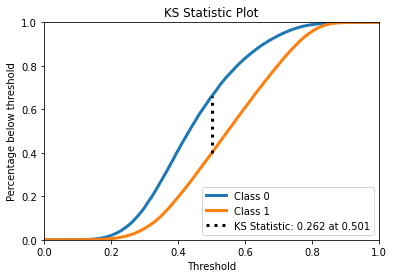

<Figure size 432x288 with 0 Axes>

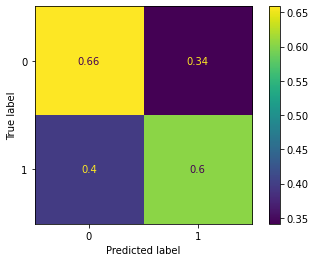

In [3]:
ds_dropado = ds.drop(labels=['IND_BOM_1_2', 'IND_BOM_1_1'], axis=1)
df_treino = treino_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(treino_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao = valid_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(valid_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_validacao.drop(columns=['INDEX'], axis=1, inplace=True)
df_teste = teste_ina.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1).append(teste_adi.drop(['IND_BOM_1_2','IND_BOM_1_1'], axis=1))
df_teste.drop(columns=['INDEX'], axis=1, inplace=True)

best_rl = []

def rl(trial):
    # penalty = trial.suggest_categorical("penalty", ["none", "l2", "l1", "elasticnet"])
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"])
    C = trial.suggest_float("C", 0.01, 1.0)
    multi_class = "ovr"
    
    # Código opcional para log
    # print('Regressão Logística com solver {} e C {}\n'.format(
    #     solver, C
    # ))

    regressao_log = LogisticRegression(max_iter=1000,
                                    random_state=1, 
                                    solver=solver, 
                                    C=C, 
                                    multi_class=multi_class).fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))

    best_rl.append(regressao_log)
    
    rl_pred_class = regressao_log.predict(df_validacao)
    rl_pred_scores = regressao_log.predict_proba(df_validacao)
    
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics_sem_plot2([0]*len(valid_ina)+[1]*len(valid_adi), rl_pred_class, rl_pred_scores,  "LR/LR Trial {}".format(trial.number))
    
    return accuracy

study_3 = optuna.create_study(direction="maximize")
study_3.optimize(rl, n_trials=64)

compute_performance_metrics([0]*len(teste_ina)+[1]*len(teste_adi), best_rl[study_3.best_trial.number].predict(df_teste), best_rl[study_3.best_trial.number].predict_proba(df_teste))
plot_confusion_matrix(best_rl[study_3.best_trial.number], df_teste, [0]*len(teste_ina)+[1]*len(teste_adi), normalize='true')

### Resultados da Regressão Logística

In [4]:
optuna.visualization.plot_optimization_history(study_3)

In [5]:
optuna.visualization.plot_slice(study_3)

In [6]:
optuna.visualization.plot_param_importances(study_3)

#### Comentários acerca dos resultados da Regressão Logística
Vimos que há uma tendência de resultados melhores na região de 0.2 até 0.26 para a variável C. Vamos afunilar e gerar mais testes nesse intervalo.

In [7]:
def rl(trial):
    # penalty = trial.suggest_categorical("penalty", ["none", "l2", "l1", "elasticnet"])
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"])
    C = trial.suggest_float("C", 0.19, 0.26)
    multi_class = "ovr"

    regressao_log = LogisticRegression(max_iter=1000,
                                    random_state=1, 
                                    solver=solver, 
                                    C=C, 
                                    multi_class=multi_class).fit(df_treino, [0]*len(treino_ina)+[1]*len(treino_adi))

    best_rl.append(regressao_log)
    
    rl_pred_class = regressao_log.predict(df_validacao)
    rl_pred_scores = regressao_log.predict_proba(df_validacao)
    
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics_sem_plot([0]*len(valid_ina)+[1]*len(valid_adi), rl_pred_class, rl_pred_scores)
    
    return accuracy

study_3 = optuna.create_study(direction="maximize")
study_3.optimize(rl, n_trials=64)

[I 2021-12-13 17:53:19,003] A new study created in memory with name: no-name-ce42977e-cad4-43c8-a88c-c1c38867c807
[I 2021-12-13 17:53:30,829] Trial 0 finished with value: 0.6315327322618581 and parameters: {'solver': 'saga', 'C': 0.24683243924552206}. Best is trial 0 with value: 0.6315327322618581.
[I 2021-12-13 17:53:49,486] Trial 1 finished with value: 0.6315327322618581 and parameters: {'solver': 'liblinear', 'C': 0.24644369495349933}. Best is trial 0 with value: 0.6315327322618581.
[I 2021-12-13 17:54:47,903] Trial 2 finished with value: 0.6315405723245786 and parameters: {'solver': 'newton-cg', 'C': 0.23096729387561515}. Best is trial 2 with value: 0.6315405723245786.
[I 2021-12-13 17:55:00,556] Trial 3 finished with value: 0.6315327322618581 and parameters: {'solver': 'saga', 'C': 0.2502997486409192}. Best is trial 2 with value: 0.6315405723245786.
[I 2021-12-13 17:55:48,734] Trial 4 finished with value: 0.6315092120736966 and parameters: {'solver': 'newton-cg', 'C': 0.2077554794

#### Comentários acerca dos resultados da Regressão Logística 2
Os resultados foram pouco distintos dos anteriores, dado que o algoritmo melhorou apenas 0.001%, ou seja, o teste mostrou que atingimos o seu melhor com os parâmetros anteriores.